# Project
### Link to GitHub Repository: https://github.com/Krissy-okaa/DSCI-100-Project

## Predicting Newsletter Subscription in a Minecraft Research Server

## Introduction

### Background

Understanding user behavior in video games is a growing area of interest for both researchers and developers. In this project, we analyze player data collected from a Minecraft research server to investigate which player characteristics and behaviors are predictive of subscribing to a game-related newsletter. This question is important because targeting players more likely to engage with the community can help optimize recruitment strategies and server resource allocation.

### Question

Can player characteristics such as experience level and total played hours predict newsletter subscription in the Minecraft dataset?


## Data Description

The dataset `players.csv` includes 196 unique players with the following variables will be su e:

The following data will be used：

- `subscribe` (factor): Whether the player subscribed to the newsletter.
- `experience` (categorical): Self-reported experience level in the game.
- `played_hours` (numeric): Total number of hours the player spent playing.


In [48]:
library(tidyverse)
library(tidymodels)

## Methods & Results

### Data Preparation

The `players.csv` dataset was loaded using `read_csv()`. The `experience` variable was converted into an ordered factor from “Beginner” to “Pro”, and `subscribe` was converted into a factor. A new dataset was created using only `subscribe` and `played_hours`.


In [49]:
players <- read_csv("players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [50]:
experience_levels <- c("Beginner", "Amateur", "Regular", "Veteran", "Pro")

model_data <- players |>
  select(subscribe, experience, played_hours) |>
  mutate(subscribe = as.factor(subscribe),
         experience = factor(experience, levels = experience_levels))

head(model_data)

subscribe,experience,played_hours
<fct>,<fct>,<dbl>
TRUE,Pro,30.3
TRUE,Veteran,3.8
FALSE,Veteran,0.0
TRUE,Amateur,0.7
TRUE,Regular,0.1
TRUE,Amateur,0.0


In [51]:
model_data |>
  group_by(experience, subscribe) |>
  summarise(count = n()) |>
  pivot_wider(names_from = subscribe, values_from = count, values_fill = 0) |>
  rename(False = `FALSE`, True = `TRUE`)

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


experience,False,True
<fct>,<int>,<int>
Beginner,8,27
Amateur,18,45
Regular,7,29
Veteran,15,33
Pro,4,10


### Exploratory Data Analysis

#### Figure 1: Proportion of Subscription Status by Experience Level

The bar chart below shows the proportion of players who subscribed and did not subscribe within each experience level. The chart shows that the influence of experience level on subscription is not very significant.


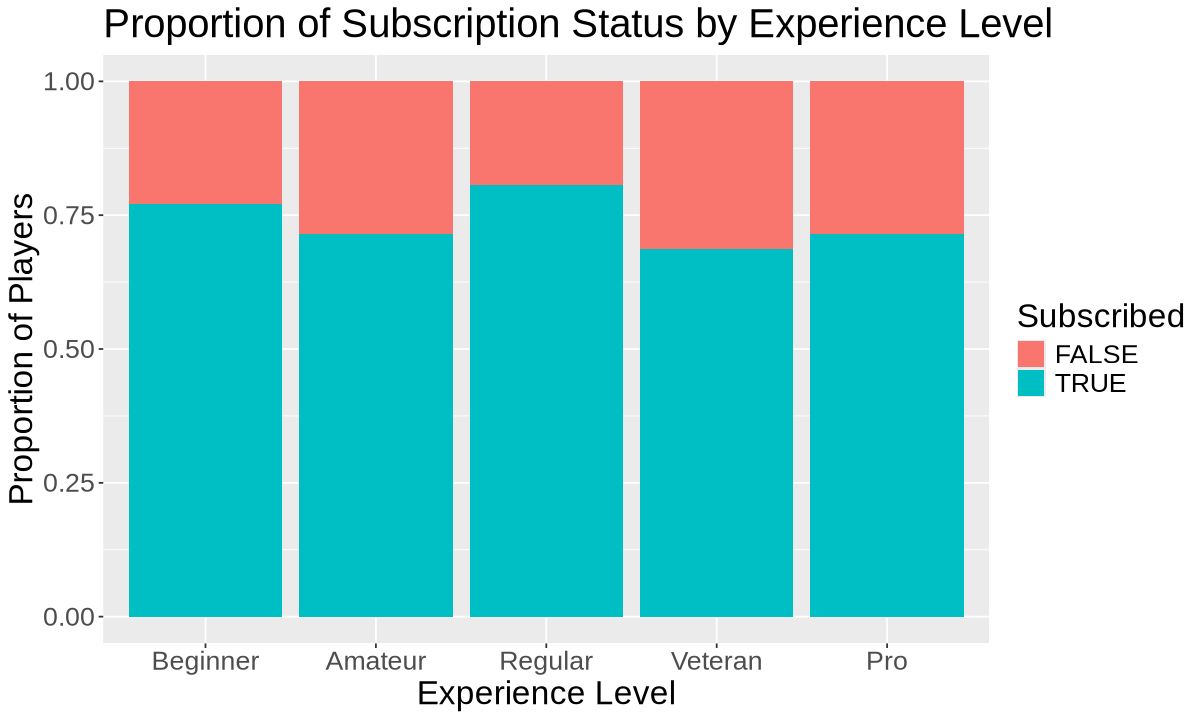

In [52]:
options(repr.plot.width = 10, repr.plot.height = 6)

experience_subscribe_counts <- model_data |>
  count(experience, subscribe)

experience_subscribe_counts |>
  ggplot(aes(x = experience, y = n, fill = subscribe)) +
  geom_bar(stat = "identity", position = "fill") +
  labs(title = "Proportion of Subscription Status by Experience Level",
       x = "Experience Level",
       y = "Proportion of Players",
       fill = "Subscribed") +
       theme(text = element_text(size = 20))

#### Figure 2: Played Hours by Subscription Status

The boxplot below compares the distribution of `played_hours` between subscribed and non-subscribed players. Subscribed players appear to have generally played more, with a higher median and more upper outliers.


In [ ]:
ggplot(model_data, aes(x = subscribe, y = played_hours, fill = subscribe)) +
  geom_boxplot() +
  labs(title = "Figure 2a: Played Hours by Subscription Status",
       x = "Subscribed",
       y = "Total Played Hours") +
  theme(text = element_text(size = 20))

ggplot(model_data, aes(x = subscribe, y = played_hours, fill = subscribe)) +
  geom_boxplot() +
  coord_cartesian(ylim = c(0, 15)) +
  labs(title = "Figure 2b: Played Hours by Subscription Status",
       x = "Subscribed",
       y = "Total Played Hours") +
  theme(text = element_text(size = 20))

### Method Justification

The visualizations used are suitable for comparing categorical variables (`experience`, `subscribe`) with numeric distributions (`played_hours`). Bar plots and boxplots are commonly used for exploratory data analysis in classification problems.

- **Assumptions**: Boxplots assume a meaningful comparison of numeric data across categorical groups, which is valid for `subscribe` as a binary factor.
- **Limitations**: The analysis does not include other potential variables, such as gender or behavioral session patterns, which may influence subscription.
- **Model Comparison**: This section is focused on initial exploratory analysis, providing visual insights into the data prior to formal predictive modeling.

### KNN Classification Model
The KNN classifier was trained using 75% of the data and tested on the remaining 25%. Only one variable, `played_hours`, was used as the predictor. Standardization was applied to the numeric predictor to ensure fair distance calculation. Model accuracy was calculated using the `metrics()` function, providing a measure of predictive performance.


In [54]:
model_data_played <- model_data |>
  select(subscribe, played_hours)

set.seed(2025)
data_split <- initial_split(model_data_played, prop = 0.75, strata = subscribe)
data_train <- training(data_split)
data_test <- testing(data_split)

knn_recipe <- recipe(subscribe ~ played_hours, data = data_train) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors())

knn_spec <- nearest_neighbor(neighbors = 5, weight_func = "rectangular") |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  fit(data = data_train)

knn_preds <- knn_fit |>
  predict(data_test) |>
  bind_cols(data_test)

knn_preds |>
 conf_mat(truth=subscribe, estimate =.pred_class)
knn_preds |>
 metrics(truth=subscribe, estimate =.pred_class)

          Truth
Prediction FALSE TRUE
     FALSE     8   23
     TRUE      5   13

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4285714
kap,binary,-0.0162963


### Discussion

This project explored whether a player’s total played hours (`played_hours`) could help predict whether they subscribed to a Minecraft newsletter (`subscribe`).

Figure 1 shows the percentage of subscribed and non-subscribed players across different experience levels. The proportions are quite similar between the levels, which suggests that a player’s experience may not have a strong connection to their decision to subscribe. Because of this, experience level was not used in the final prediction.

Figure a shows a boxplot of `played_hours` by subscription status. Because some players played a lot more than others, the plot includes a few extreme values that made the box hard to read. Most players had fewer hours, so the center of the data was hard to see.

To fix this, Figure b shows the same plot but zoomed in to only display 0–15 hours. This makes the difference easier to see. Subscribed players had a higher median and a wider spread of play time, meaning they tend to play more than non-subscribed players.

Even though this trend is visible, the KNN model was not able to make accurate predictions. It had an accuracy of about **42.9%**, which is lower than random guessing. The difference in game time between the groups was not strong or consistent enough to be useful on its own.

To improve prediction in future work, it would be helpful to include more information—such as how often players log in, how long their sessions are, or other patterns of behavior during gameplay.
